# Lab 6:  SVMs on an Extended  MNIST 

In addition to the concepts in the [MNIST demo](mnist_svm.ipynb), you will learn:

* Use the `skimage` module for some basic pre-processing of images in machine learning
* Run and test an SVM classifier on a dataset you have created
* Perform error handling in python

In the [MNIST demo](mnist_svm.ipynb), we saw how SVMs can be used for the classic MNIST problem of digit recognition.  In this lab, we are going to extend the MNIST dataset by adding a number of non-digit letters and see if the classifier can distinguish the digits from the non-digits.  All non-digits will be lumped as a single 11-th class.  In image processing, this is called a 'detection' as opposed to 'classification' problem.  Detection is vital in OCR and related problems since the non useful characters must be rejected.  For this lab we will create a very simple version of this problem.

## Loading the MNIST data

We first import the standard modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Next, fetch the digits with `fetch_mldata` command as shown in the demo.  Save the digits data matrix and labels to variables `Xdig` and `ydig`.  Also, recall that the pixel values in `Xdig` are between 0 and 255.  Create a scaled version of `Xdig` called `Xdigs` where the components are between -1 and 1.

In [3]:
# TODO
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist.data.shape


(70000, 784)

In [5]:
Xdig = mnist.data
ydig = mnist.target 
Xdigs = (Xdig - 127.5)/127.5

Create a function `plt_digit` that plots the digits.  You can use the code from the demo.  Test the function by plotting four random digits.  Use the `plt.title` command to print the numeric label in `ydig` above each digit.

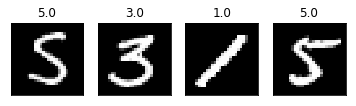

In [9]:
# TODO: Select four random digits and plot them using the subplot command
def plt_digit(x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])

# Select random digits
nplt = 4
nsamp = Xdig.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    #print(Xdigs[ind,:])
    plt_digit(Xdigs[ind,:])
    plt.title(str(ydig[ind]))

## Exception Handling

In the routines we will develop below, we will need to handle error conditions, called exceptions. A very nice description of how to perform exception handling in python is given in

https://docs.python.org/3/tutorial/errors.html

As described there, errors are described by a class that derives from a base class Exception. When the error occurs, the program raises the exception with the raise command. The calling function can catch the exception with the try ... except control flow. We will define our exception as follows which has an optional string argument.

In [299]:
class ImgException(Exception):
    def __init__(self, msg='No msg'):
        self.msg = msg

Exceptions are used as follows:  First, when there is an error in some function, you `raise` the exception as follows:

    foo():
        ...
        if (error):
           raise ImgException("File not found")
           
        # Code that will not execute if the error condition occured
        
     
The function that calls `foo()` can catch the error using the following syntax:

    try: 
        foo()
        
        # Continue processing in case when there was no exception
        ....
        
    except ImgException as e:
        print("foo() didn't work")
        print("Error msg = %s" % e.msg)

## Get Non-Digit Characters

We will now build a set of non-digit characters.  As a simple source, we will get hand-written lowercase letters 'a' to 'z' and process them with the `skimage` package.  The `skimage` module is a very powerful package that has a similar interface as OpenCV.  We first import the relevant modules.

In [300]:
import matplotlib.image as mpimg
import skimage.io
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.transform import resize
import matplotlib.patches as mpatches
from skimage import data
import skimage

We can get a set of character images from a very nice website

http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

Go to this website, and download the file `EnglishHnd.tgz`.  After you untar this file, there are a large number of `.png` files in the directory:

    EnglishHnd\English\Hnd\Img
    
Each directory has about 55 samples of hand-written letters and numbers.  After you have downloaded this file, complete the function `load_img` to load an image from a character and sample index.

Alternatively, the files are available on Google Drive:

https://drive.google.com/file/d/0BxOz-SM9a1h4UksxSXBjQ0dabUk/view?usp=sharing 

You can download and unzip the file.

The code at the end will test the function to see if it working correctly.  For one sample, it should print the image and a second it should say the file was not found.

In [301]:
import os.path

def load_img(char_ind, samp_ind):
    """
    Returns the image from the dataset given a character and sample index.
    
        
    If the file doesn't exist, it raises an Exception with the filename.   
    """ 
    
    # TODO:  Set the file name based on char_ind and samp_ind
    if char_ind<=9 and samp_ind<=9:
        fname = "img00"+str(char_ind)+"-00"+str(samp_ind)+".png"
    elif char_ind<=9 and samp_ind>9:
        fname = "img00"+str(char_ind)+"-0"+str(samp_ind)+".png"
    elif char_ind>9 and samp_ind<=9:
        fname = "img0"+str(char_ind)+"-00"+str(samp_ind)+".png"
    else: 
        fname = "img0"+str(char_ind)+"-0"+str(samp_ind)+".png"
        
    # TODO:  Use the os.path.isfile command to check if the file exists.  
    # If not raise an ImgException with the message "[fname] not found"
    if char_ind<=9:
        check = os.path.isfile("EnglishHnd/EnglishHnd/English/Hnd/\
                               Img/Sample00"+str(char_ind)+"/"+str(fname))
    else:
        check = os.path.isfile("EnglishHnd/EnglishHnd/English\
                               /Hnd/Img/Sample0"+str(char_ind)+"/"+str(fname))
    
    if (check):
        pass
    else:
        raise ImgException("Sample0" + str(char_ind)\
                           +"\\" + str(fname) + " not found")

    if char_ind<=9:
        ffname = "EnglishHnd/EnglishHnd/English/Hnd/Img/Sample00"\
                                            +str(char_ind)+"/"+str(fname)
    else:
        ffname = "EnglishHnd/EnglishHnd/English/Hnd/Img/Sample0"\
                                            +str(char_ind)+"/"+str(fname)
    # TODO:  Use the skimage.io.imread() command to read the png file and return the image.
    img = skimage.io.imread(ffname)
    return img



Test the `load_img` function.  This should:
* Plot the image in `Sample047\img047-006.png`
* Say that the `Sample047\img047-070.png` is not found.

Char = 47 samp=6


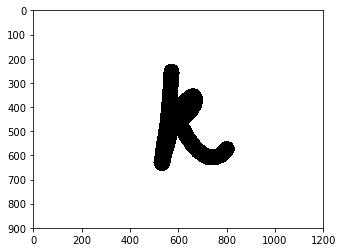

Char = 47 samp=70
Sample047\img047-070.png not found


In [302]:
char_ind = 47
samp_inds = [6,70]
for samp_ind in samp_inds:
    try:
        print("Char = %d samp=%d" % (char_ind, samp_ind))
        img = load_img(char_ind=char_ind, samp_ind=samp_ind)
       
        plt.imshow(img)
        plt.show()
    except ImgException as e:
        print(e.msg)
        


The images in the sample directory have very high resolution.  Complete the following method to find the image and place it in a 28 x 28 box.  You can look at this very nice demo of the `skimage` methods here:

http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

The code is somewhat complex, so I have provided some of the steps, esp. for the thresholding.

In [303]:
def mnist_resize(img):
    """
    Extracts a character from the image, and places in a 28x28 image to match the MNIST format.
    
    Returns:
    img1:  MNIST formatted 28 x 28 size image with the character from img
    box:   A bounding box indicating the locations where the character was found in img.    
    """
    # Image sizes (fixed for now).  To match the MNIST data, the image 
    # will be first resized to 20 x 20.  Then, the image will be placed in center of 28 x 28 box
    # offet by 4 on each side.
    nx_img = 20   
    ny_img = 20
    nx_box = 28   
    ny_box = 28
    offx = 4
    offy = 4
    
    # TODO:  Convert the image to gray scale using the skimage.color.rgb2gray method.
    bw = skimage.color.rgb2gray(img)
    
    # Threshold the image using OTSU threshold
    thresh = threshold_otsu(bw)
    bw = closing(bw < thresh, square(3)).astype(int)
#     print('BW',bw)
#     plt.imshow(bw)
#     plt.show()
    
    # Get the regions in the image.
    # This creates a list of regions in the image where the digit possibly is.
    regions = regionprops(bw)

    # TODO:  Find region with the largest area.  You can get the region area from region.area.
    
    regions_areas = [region.area for region in regions]
    region_max = regions[np.argmax(np.array(regions_areas))]
    area_max = max(np.array(regions_areas))
    # Raise an ImgException if no region with area >= 100 was found
    if (area_max < 100):
        raise ImgException("No image found")    
                
    # Get the bounding box of the character from region_max.bbox
    minr, minc, maxr, maxc = region_max.bbox
    box = [minr,minc,maxr,maxc]
    
    # TODO:  Crop the image in bw to the bounding box
    bw_crop = bw[minr:maxr,minc:maxc]
        
    # TODO:  Resize the cropped image to a 20x20 using the resize command.
    # You will need to use the mode = 'constant' option
    bw_resize = resize(bw_crop,output_shape = (nx_img,ny_img),mode='constant')

    # TODO:  Threshold back to a 0-1 image by comparing the pixels to their mean value
    mean = np.mean(np.array(np.ravel(bw_resize)))
#     mi = min(rav)
#     ma = max(rav)

    t_b = bw_resize > mean
    img_ext = t_b.astype(int)
    
    x_flank = np.zeros((20,4))
    ju = np.column_stack((x_flank,img_ext,x_flank))
    y_flank = np.zeros((4,28))
    img1 = np.vstack((y_flank,ju,y_flank))
#     plt.imshow(img1,cmap='gray')
#     plt.show()

    return img1, box

Now test the `mnist_resize` program by completing the following code.  Create two subplots:
* subplot(1,2,1):  The original image with the bounding box for the character that was found in the image.
* subplot(1,2,2):  The MNIST resized image.

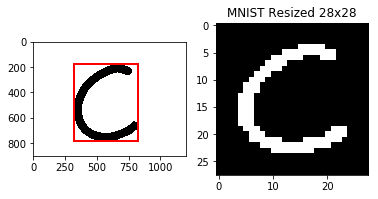

In [304]:
# Load an image
img = load_img(13,9)

try:
    # Resize the image
    img1, box = mnist_resize(img)
    minc = box[1]
    minr = box[0]
    maxr = box[2]
    maxc = box[3]
    # TODO:  Plot the original image, img, along with a red box around the captured character.
    # Use the mpatches.Rectangle and ax.add_patch methods to construct the rectangle.

    fig,[ax1,ax2]= plt.subplots(nrows=1,ncols=2)
    ax1.imshow(img)
    
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    ax1.add_patch(rect)
    

    # TODO:  Plot the resized 28 x 28 image, img1.  You can use the plt_digit(img1) command 
    img1 
    ax2.imshow(img1,cmap = 'gray')
    #print(img1)
    plt.title('MNIST Resized 28x28')
    plt.show()
       
except ImgException as e:
    print(e.msg)



Now, run the command `nlet=1000` times to get 1000 letter images.  In each iteration, select a random image from a lowercase letter and add it to a matrix `Xlet`. 

In [386]:
# Dimensions
nlet = 1000
nrow = 28
ncol = 28
npix = nrow*ncol
Xlet = np.zeros((nlet, npix))

i = 0
while i < nlet:
    # TODO:  Generate a random character and sample    
    #45 and 51 are character indices for 'O' and 'I'
    
    li = [n for n in range(37,63) if (n!=45 and n!=51)] #all lower case letters except 'O' and 'I'
    char_ind = np.random.choice(li)
    samp_ind = np.random.randint(0,50)
  
        
    try:
        # TODO:  Load the image with load_img function
        img = load_img(char_ind,samp_ind)
        
        # TODO:  Reize the image with mnist_resize function
        img1, box = mnist_resize(img)
        
        # TODO:  Store the image in a row of Xlet[i,:] and increment i
        Xlet[i,:] = np.ravel(img1)
        i += 1
        
        # Print progress
        if (i % 50 == 0):
            print ('images captured = {0:d}'.format(i))
    except ImgException:
        # Skip if image loading or resizing failed
        pass

images captured = 50
images captured = 100
images captured = 150
images captured = 200
images captured = 250
images captured = 300
images captured = 350
images captured = 400
images captured = 450
images captured = 500
images captured = 550
images captured = 600
images captured = 650
images captured = 700
images captured = 750
images captured = 800
images captured = 850
images captured = 900
images captured = 950
images captured = 1000


Since this takes a long time to generate, save the matrix `Xlet` to a file `Xlet.p` using the `pickle.dump` command.

In [387]:
import pickle

with open('Xlet.p', 'wb') as xlet:
    pickle.dump(Xlet, xlet)

Reload the data `Xlet` from the file `Xlet.p`

In [388]:
Xlet = pickle.load( open( "Xlet.p", "rb" ) )

## Create Extended Training Data

Now, create an extended data set by combining `ndig=5000` randomly selected digit samples and `nlet=1000` letters. 
* Select `ndig=5000` random samples from `Xdigs` and their labels in `ydig`.
* Rescale the letters `Xlet` to a new matrix `Xlets = 2*Xlet-1` to make the pixel values go from -1 to 1.
* Use the `np.vstack` command to create a 6000 element alpha-numeric data set `X`
* Create a corresponding label vector `y` where all the non-digit characters are labeled with a non-digit label, `letter_lbl=10`.


In [389]:
# TODO
Xlets = (2*Xlet) - 1 
#print(Xlets.shape[0])
letter_lbl = 10
ylet = letter_lbl*np.ones(Xlets.shape[0])
ylet =ylet.reshape(Xlets.shape[0],1)
ndig = 5000
nrow = 28
ncol = 28
npix = nrow*ncol
Xdigi = np.zeros((ndig, npix))
ydigi = np.zeros((ndig,1))
j=0
rand_per = np.random.permutation(Xdigs.shape[0])
while j<ndig: 
    rand_samp = rand_per[j]
    
    Xdigi[j,:] = Xdigs[rand_samp]
    ydigi[j,0] = ydig[rand_samp]
    j+=1
    
    if (j % 1000 == 0):
            print ('images captured = {0:d}'.format(j))
ydigi = ydigi.reshape(ndig,1)
X = np.vstack((Xdigi,Xlets))
y = np.vstack((ydigi,ylet))
# print(X.shape)
# print(y[4950:5050])

images captured = 1000
images captured = 2000
images captured = 3000
images captured = 4000
images captured = 5000


# Run the SVM classifier

First create the SVM classifer.  Use an "rbf" classifier with `C=2.8` and `gamma=.0073`.  Not sure if these are the best parameters, you could try to search for better ones.

In [390]:
from sklearn import svm

# TODO:  Create a classifier: a support vector classifier
svc = svm.SVC(C=2.8,kernel='rbf',gamma=0.0073)

Get 5000 training samples `Xtr,ytr` and 1000 test samples `Xts,yts`.  Remember to randomly select them.

In [391]:
# TODO
r = np.random.permutation(X.shape[0])
train_rows = r[0:5000]
test_rows = r[5000:]
# # print(len(train_rows))
# # print(len(test_rows))
# # print(train_rows in train_rows)
# trialx = X[train_rows,:]
# trialy = y[train_rows,:]
# print(len(np.where(trialy==10)[0]))
Xtr = X[train_rows,:]
ytr = y[train_rows,:]
ytr = ytr.reshape(5000,)
Xts = X[test_rows,:]
yts = y[test_rows,:]
yts = yts.reshape(1000,)

Use the `svc.fit` command to fit on the training data.  This may take a few minutes

In [392]:
svc.fit(Xtr,ytr)

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0073, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Measure the accuracy on the test samples.  You should get about 96% accuracy.  You can get better by using more training samples, but it will just take longer to run.

In [393]:
ypred = svc.predict(Xts)

correct = [1 for i in range(0,len(ypred)) if ypred[i] == yts[i]]
accuracy = len(correct)/len(ypred)
print('Accuracy: '+str(accuracy*100) +"%")

Accuracy: 96.3%


Print the normalized confusion matrix

In [394]:
# TODO
from sklearn.metrics import confusion_matrix
label = np.linspace(0,10,11)
CM = confusion_matrix(yts, ypred, labels=label)
CM_sum = np.sum(CM,axis = 1).reshape(11,1)
CM_N = CM/CM_sum
print('NORMALIZED CONFUSION MATRIX\n')
print(np.array_str(CM_N, precision=3, suppress_small=True))

NORMALIZED CONFUSION MATRIX

[[ 0.974  0.     0.     0.     0.     0.     0.     0.     0.     0.013
   0.013]
 [ 0.     0.989  0.     0.011  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.961  0.     0.     0.     0.     0.01   0.01   0.     0.02 ]
 [ 0.011  0.     0.021  0.926  0.     0.011  0.     0.     0.021  0.     0.011]
 [ 0.     0.     0.     0.     0.955  0.     0.     0.015  0.     0.03   0.   ]
 [ 0.     0.     0.013  0.     0.     0.949  0.026  0.     0.013  0.     0.   ]
 [ 0.014  0.     0.     0.     0.     0.     0.971  0.     0.     0.     0.014]
 [ 0.     0.     0.     0.     0.013  0.     0.     0.961  0.     0.026  0.   ]
 [ 0.     0.     0.012  0.012  0.     0.     0.     0.     0.964  0.     0.012]
 [ 0.     0.     0.     0.021  0.     0.     0.     0.043  0.011  0.915
   0.011]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     1.   ]]


## Plotting some error samples

We now plot some errors.  Plot up to four images where yhat == 10 but yts != 10.  That is, the true image was a digit, but the classifier classified it as a non-digit.  Note there may be less than four such errors (when I ran it I got only three such errors).  In that case, just plot only the errors you got.  If there are no errors, print "No such error found"

Indices where yhat==10 and yts!=10: 
 [52, 338, 393, 544, 671, 705, 983]


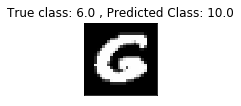

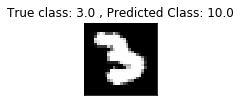

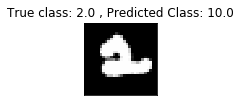

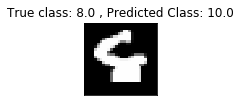

In [424]:
# TODO
ind = [i for i in range(0,yts.shape[0]) if (ypred[i] == 10 and yts[i]!=10) ]
# yts.shape[0]
print('Indices where yhat==10 and yts!=10: \n',ind)
ind = ind[0:4]
if len(ind) ==0: 
    print('No such error found!')

else:
    
    k=1
    for ele in ind:
        plt.subplot(1,4,k)
        plt_digit(Xts[ele,:])
        plt.title('True class: '+str(yts[ele]) +' , Predicted Class: '+str(ypred[ele]))
        k+=1
        plt.show()

Now plot up to four images where yhat != 10, but yts == 10.  That is, the image was a non-digit, but the classifier thought it was an image.  I happened to get no such images.  If you find no such examples, print "No such error found".

In [425]:
# TODO
ind = [i for i in range(0,yts.shape[0]) if (ypred[i] != 10 and yts[i]==10)]
# yts.shape[0]
#print('Indices where yhat!=10 and yts==10: \n',ind)
ind = ind[0:4]
if len(ind) ==0: 
    print('No such error found!')
else: 
    k=0
    for ele in ind:
        plt.subplot(1,4,k)
        plt_digit(Xts[ele,:])
        plt.title('True class: '+str(yts[ele]) +' , Predicted Class: '+str(ypred[ele]))
        k+=1
        plt.show()

No such error found!


Finally, plot up to four images where yts != yhat and both yts < 10 and yhat < 10.

Indices where yts != yhat and both yts < 10 and yhat < 10: 
 [10, 61, 118, 162, 168, 188, 254, 272, 423, 475, 489, 533, 553, 585, 616, 620, 640, 663, 668, 763, 781, 816, 819, 880, 890, 893, 931, 940, 967, 971]


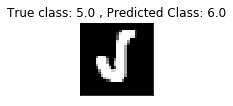

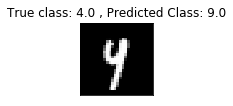

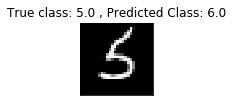

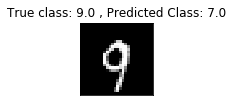

In [426]:
# TODO
ind = [i for i in range(0,yts.shape[0]) if ((yts[i]!=ypred[i]) \
                                        and yts[i]<10 and ypred[i]<10)]
# yts.shape[0]
print('Indices where yts != yhat and both yts < 10 and yhat < 10: \n',ind)
ind = ind[0:4]
k=1
for ele in ind:
    plt.subplot(1,4,k)
    plt_digit(Xts[ele,:])
    plt.title('True class: '+str(yts[ele]) +' , Predicted Class: '+str(ypred[ele]))
    k+=1
    plt.show()